In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import asarray
from numpy import save
from numpy import load
import tensorflow as tf
import tensorflow.keras as keras
import pickle
import joblib
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [34]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [35]:
sns.set_style("white")

### Load Data

In [36]:
with open ('../data/lstm_mlp/label_keys', 'rb') as fp:
    label_keys = pickle.load(fp)
with open ('../data/lstm_mlp/feature_keys', 'rb') as fp:
    feature_keys = pickle.load(fp)    

train_unsc = pd.read_pickle("../data/lstm_mlp/train_unsc_ts.pkl")
valid_unsc = pd.read_pickle("../data/lstm_mlp/valid_unsc_ts.pkl")
test_unsc = pd.read_pickle("../data/lstm_mlp/test_unsc_ts.pkl")
all_train_unsc = pd.read_pickle("../data/lstm_mlp/all_train_unsc_ts.pkl")

scaler_x = joblib.load("../data/lstm_mlp/scaler_all_train_x.save") 
scaler_y = joblib.load("../data/lstm_mlp/scaler_all_train_y.save") 

scaler_train_x = joblib.load("../data/lstm_mlp/scaler_train_valid_x.save") 
scaler_train_y = joblib.load("../data/lstm_mlp/scaler_train_valid_y.save")

train_norm = pd.read_pickle("../data/lstm_mlp/train_scaled.pkl")
valid_norm = pd.read_pickle("../data/lstm_mlp/valid_scaled.pkl")
test_norm = pd.read_pickle("../data/lstm_mlp/test_scaled.pkl")
all_train_norm = pd.read_pickle("../data/lstm_mlp/all_train_scaled.pkl")

train_x = load('../data/lstm_mlp/train_x_norm.npy')
train_y = load('../data/lstm_mlp/train_y_norm.npy')
valid_x = load('../data/lstm_mlp/valid_x_norm.npy')
valid_y = load('../data/lstm_mlp/valid_y_norm.npy')
test_x = load('../data/lstm_mlp/test_x_norm.npy')
test_y = load('../data/lstm_mlp/test_y_norm.npy')
all_train_x = load('../data/lstm_mlp/all_train_x_norm.npy')
all_train_y = load('../data/lstm_mlp/all_train_y_norm.npy')

cc4_data = pd.read_csv("../data/ts_data.csv") 

### Load Model LSTM Dropout Model

In [37]:
model = keras.models.load_model("../data/lstm_mlp/lstm_models/LSTMDropout_model_test")

### Prepare data to look at single sequences

In [38]:
## transform data so that each sequence so that we have measured values and prediction 
## for each sequence separately

## transform into (samples, time steps, features) format
def lstm_format(data):
    length_cc4 = 15.42
    seq_len = 5  #only 5 time steps in the past
    features = []
    labels = []
    data_set = {}

    for _, group in data.groupby('seq_id'):
        for i in range(len(group)-(seq_len-1)):
            features.append(group[feature_keys].iloc[i:i+seq_len].to_numpy())  
            labels.append(group[label_keys].iloc[i+(seq_len-1)].to_numpy())

    data_set['x'] = np.stack(features)
    data_set['y'] = np.stack(labels)
    return data_set

test_seq = test_norm['seq_id'].drop_duplicates()

x = {}
y = {}
for seq in test_seq:
    df = lstm_format(test_norm[test_norm['seq_id']==seq])
    x[seq]= df['x'].copy()
    y[seq] = df['y'].copy()

## predicted and measured values
prediction = {}
real_values = {}
rmse = {}
for seq in test_seq:
    prediction[seq] = scaler_y.inverse_transform(model.predict(x[seq]))
    real_values[seq] = scaler_y.inverse_transform(y[seq])
    rmse[seq] = np.sqrt(mean_squared_error( prediction[seq],  real_values[seq]))  

error = []
for seq in test_seq:
    error.append((rmse[seq], seq))

In [39]:
sorted(error)

[(2.2555111276099185, '471719_str_2'),
 (2.2555111276099185, '471724_str_2'),
 (2.2555111276099185, '471728_str_2'),
 (2.7590317555287607, '471719_str_1'),
 (2.7590317555287607, '471724_str_1'),
 (2.7590317555287607, '471728_str_1')]

In [40]:
water_keys = ['WasserZ4FsInLproMin_integr', 'WasserZ4LsInLproMin_integr',
       'WasserZ2bFsInLproMin_integr', 'WasserZ2bLsInLproMin_integr',
       'WasserZ3bFsInLproMin_integr', 'WasserZ1FsInLproMin_integr',
       'WasserZ3bLsInLproMin_integr', 'WasserZ1LsInLproMin_integr',
       'WasserZ3aFsInLproMin_integr', 'WasserZ3aLsInLproMin_integr',
       'WasserZ2aLsInLproMin_integr', 'WasserZ2aFsInLproMin_integr',
       'WasserZ5LsInLproMin_integr', 'WasserZ5FsInLproMin_integr',
       
             ]
not_water_keys = [e for e in feature_keys if e not in water_keys]

### Change values of specific features

In [41]:
## Function that plots the measured temperature, the original prediciton and the new prediction
def new_predicition_plot(test_change_unsc, test_change_unsc_2, descr_change, descr_change_2):
    id_test = test_change_unsc['seq_id'].to_frame()
    id_test =id_test.reset_index(drop=True)

    test_change_x = scaler_x.transform(test_change_unsc[feature_keys])
    test_change_x = pd.DataFrame(test_change_x, columns=(feature_keys))
    test_change_y = scaler_y.transform(test_change_unsc[label_keys])
    test_change_y = pd.DataFrame(test_change_y, columns=(label_keys))

    test_change = pd.concat([test_change_y,test_change_x],axis=1)
    test_change = pd.concat([test_change,id_test],axis=1)
    test_change = test_change.reset_index(drop=True)

    df = lstm_format(test_change)
    x_change = df['x'].copy()

    prediction_change = scaler_y.inverse_transform(model.predict(x_change))
    rmse_change = np.sqrt(mean_squared_error(prediction_change, real_values[seq])) 
    print("new RMSE",descr_change, " :" , rmse_change)
    
    test_change_x_2 = scaler_x.transform(test_change_unsc_2[feature_keys])
    test_change_x_2 = pd.DataFrame(test_change_x_2, columns=(feature_keys))
    test_change_y_2 = scaler_y.transform(test_change_unsc_2[label_keys])
    test_change_y_2 = pd.DataFrame(test_change_y_2, columns=(label_keys))

    test_change_2 = pd.concat([test_change_y_2,test_change_x_2],axis=1)
    test_change_2 = pd.concat([test_change_2,id_test],axis=1)
    test_change_2 = test_change_2.reset_index(drop=True)

    df_2 = lstm_format(test_change_2)
    x_change_2 = df_2['x'].copy()

    prediction_change_2 = scaler_y.inverse_transform(model.predict(x_change_2))
    rmse_change_2 = np.sqrt(mean_squared_error(prediction_change_2, real_values[seq]  )) 
    print("new RMSE",descr_change_2, " :" , rmse_change_2)
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5),  sharex=True, sharey=True)
    ax1.plot(real_values[seq][:,:1], color='black', label='measured')
    ax1.plot(prediction[seq][:,:1], color='blue', label='original predicted')

    ax1.plot(prediction_change[:,:1], color='red', label=descr_change)
    ax1.plot(prediction_change_2[:,:1], color='green', label=descr_change_2)

    ax1.set_xlabel('Minutes', fontsize=15)
    ax1.set_ylabel('Temperature [°C]',fontsize=15)
    ax1.xaxis.grid(True)
    ax1.yaxis.grid(True)
    ax1.legend(loc='best', prop={'size': 13})
    ax1.set(yticks=[])

### Change casting target temperature

Features that can be changed:

In [42]:
feature_keys

['TundishTemperaturInC',
 'WasserZ4FsInLproMin_integr',
 'WasserZ4LsInLproMin_integr',
 'WasserZ2bFsInLproMin_integr',
 'WasserZ2bLsInLproMin_integr',
 'WasserZ3bFsInLproMin_integr',
 'WasserZ1FsInLproMin_integr',
 'WasserZ3bLsInLproMin_integr',
 'WasserZ1LsInLproMin_integr',
 'WasserZ3aFsInLproMin_integr',
 'WasserZ3aLsInLproMin_integr',
 'WasserZ2aLsInLproMin_integr',
 'WasserZ2aFsInLproMin_integr',
 'WasserZ5LsInLproMin_integr',
 'WasserZ5FsInLproMin_integr',
 'GiessLaengeSchmelzeInM',
 'GiessLaengeSequenzInM',
 'AusfLaengeSchmelzeInM',
 'LiquidusTempInC',
 'SolidusTempInC',
 'UeberhitzungMittelInK',
 'ZielTempTreiberInC',
 'SollGiessGeschwInMproMin',
 'C-Aequiv01',
 'C-Aequiv02',
 'C-AequivP',
 'GiessLaengeSequenzInM_delta',
 'AusfLaengeSchmelzeInM_delta',
 'Format_2235']

new RMSE high casting target temp  : 22.414618101212017
new RMSE low casting target temp  : 22.039537365790398


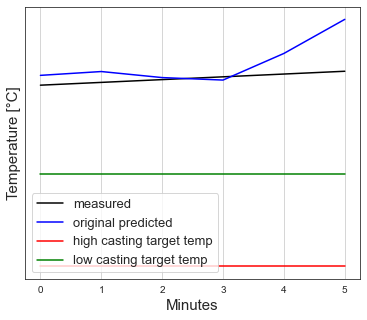

In [43]:
seq = '471719_str_2'  ## choose sequence 
test_change_unsc = test_unsc[test_unsc['seq_id']==seq].copy() ##test data of chosen sequence
test_change_unsc_2 = test_change_unsc.copy()

features_changed =  ['ZielTempTreiberInC']  ## choose features to change
features_changed_2 = ['ZielTempTreiberInC'] ## choose second features to change

descr_change = "high casting target temp" ## description of first new prediction in plot
descr_change_2 = "low casting target temp" ## description of second new prediction in plot

for col in features_changed:
    test_change_unsc[col].values[:] = cc4_data[col].min() /1.5   ## set value for each feature
    test_change_unsc_2[col].values[:] = cc4_data[col].max() *1.5
    
new_predicition_plot(test_change_unsc, test_change_unsc_2, descr_change, descr_change_2 )

### Change cooling water quantities

All cooling water features:

In [44]:
water_keys

['WasserZ4FsInLproMin_integr',
 'WasserZ4LsInLproMin_integr',
 'WasserZ2bFsInLproMin_integr',
 'WasserZ2bLsInLproMin_integr',
 'WasserZ3bFsInLproMin_integr',
 'WasserZ1FsInLproMin_integr',
 'WasserZ3bLsInLproMin_integr',
 'WasserZ1LsInLproMin_integr',
 'WasserZ3aFsInLproMin_integr',
 'WasserZ3aLsInLproMin_integr',
 'WasserZ2aLsInLproMin_integr',
 'WasserZ2aFsInLproMin_integr',
 'WasserZ5LsInLproMin_integr',
 'WasserZ5FsInLproMin_integr']

new RMSE low cooling water all zones  : 10.696708474443756
new RMSE high cooling water all zones  : 12.355638112667934


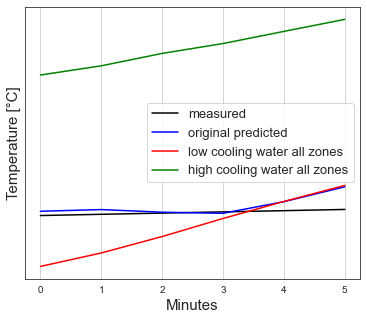

In [45]:
seq = '471719_str_2'  ## choose sequence 
test_change_unsc = test_unsc[test_unsc['seq_id']==seq].copy() ##test data of chosen sequence
test_change_unsc_2 = test_change_unsc.copy()

features_changed =  water_keys  ## choose features to change
features_changed_2 = water_keys ## choose second features to change

descr_change = "low cooling water all zones" ## description of first new prediction in plot
descr_change_2 = "high cooling water all zones" ## description of second new prediction in plot

for col in features_changed:
    test_change_unsc[col].values[:] = cc4_data[col].min()   ## set value for each feature
    test_change_unsc_2[col].values[:] = cc4_data[col].max() 
    
new_predicition_plot(test_change_unsc, test_change_unsc_2, descr_change, descr_change_2 )

### Change casting speed

In [46]:
feature_keys

['TundishTemperaturInC',
 'WasserZ4FsInLproMin_integr',
 'WasserZ4LsInLproMin_integr',
 'WasserZ2bFsInLproMin_integr',
 'WasserZ2bLsInLproMin_integr',
 'WasserZ3bFsInLproMin_integr',
 'WasserZ1FsInLproMin_integr',
 'WasserZ3bLsInLproMin_integr',
 'WasserZ1LsInLproMin_integr',
 'WasserZ3aFsInLproMin_integr',
 'WasserZ3aLsInLproMin_integr',
 'WasserZ2aLsInLproMin_integr',
 'WasserZ2aFsInLproMin_integr',
 'WasserZ5LsInLproMin_integr',
 'WasserZ5FsInLproMin_integr',
 'GiessLaengeSchmelzeInM',
 'GiessLaengeSequenzInM',
 'AusfLaengeSchmelzeInM',
 'LiquidusTempInC',
 'SolidusTempInC',
 'UeberhitzungMittelInK',
 'ZielTempTreiberInC',
 'SollGiessGeschwInMproMin',
 'C-Aequiv01',
 'C-Aequiv02',
 'C-AequivP',
 'GiessLaengeSequenzInM_delta',
 'AusfLaengeSchmelzeInM_delta',
 'Format_2235']

new RMSE low casting speed  : 20.510355760664837
new RMSE high casting speed  : 5.077276169483227


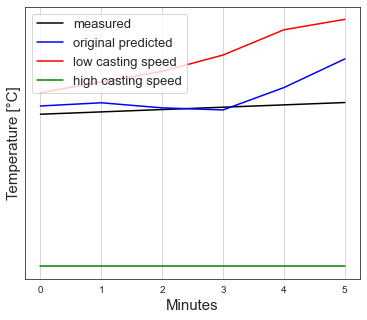

In [47]:
seq = '471719_str_2'  ## choose sequence 
test_change_unsc = test_unsc[test_unsc['seq_id']==seq].copy() ##test data of chosen sequence
test_change_unsc_2 = test_change_unsc.copy()

features_changed =  ['SollGiessGeschwInMproMin','GiessLaengeSequenzInM_delta']   ## choose features to change
features_changed_2 = ['SollGiessGeschwInMproMin','GiessLaengeSequenzInM_delta'] ## choose second features to change

descr_change = "low casting speed" ## description of first new prediction in plot
descr_change_2 = "high casting speed" ## description of second new prediction in plot

for col in features_changed:
    test_change_unsc[col].values[:] = cc4_data[col].min() /2   ## set value for each feature
    test_change_unsc_2[col].values[:] = cc4_data[col].max() *2
    
new_predicition_plot(test_change_unsc, test_change_unsc_2, descr_change, descr_change_2 )

### Effect of changes to average predicted temperature

#### Mean of new predicted temperature for whole test set
Here for casting target temperature as an example:

In [48]:
## Set values to change
all_test_change_unsc = test_unsc.copy()
features_changed = ['ZielTempTreiberInC']
for col in features_changed:
    all_test_change_unsc[col].values[:] = cc4_data[col].min() / 2

In [49]:
id_test = all_test_change_unsc['seq_id'].to_frame()
id_test =id_test.reset_index(drop=True)

test_change_x = scaler_x.transform(all_test_change_unsc[feature_keys])
test_change_x = pd.DataFrame(test_change_x, columns=(feature_keys))
test_change_y = scaler_y.transform(all_test_change_unsc[label_keys])
test_change_y = pd.DataFrame(test_change_y, columns=(label_keys))

test_change = pd.concat([test_change_y,test_change_x],axis=1)
test_change = pd.concat([test_change,id_test],axis=1)
test_change = test_change.reset_index(drop=True)

df = lstm_format(test_change)
x_change= df['x'].copy()

prediction_change = scaler_y.inverse_transform(model.predict(x_change))
print('Mean of new predicted temperature for whole test set:')
prediction_change.mean()

Mean of new predicted temperature for whole test set:


749.3637

#### Mean of original predicted temperature for whole test set

In [50]:
original_prediction = scaler_y.inverse_transform(model.predict(test_x))
print('Mean of original predicted temperature for whole test set:')
original_prediction.mean()

Mean of original predicted temperature for whole test set:


773.2701

#### Mean of original predicted temperature for a sequence
Since we only have limited data, no differences between mean for whole test set or mean for each sequence

In [51]:
test_seq = test_change['seq_id'].drop_duplicates()  ## als sequence ids in test set

x_all_changed = {}
y_all_changed = {}
for seq in test_seq:
    df = lstm_format(test_change[test_change['seq_id']==seq])
    x_all_changed[seq]= df['x'].copy()
    y_all_changed[seq] = df['y'].copy()
mean_temp = []
prediction_all_changed = {}  ## new predictions for each sequence in test set
for seq in test_seq:
    prediction_all_changed[seq] = scaler_y.inverse_transform(model.predict(x_all_changed[seq]))
    mean_temp.append(prediction_all_changed[seq].mean())
    
print('Mean of new predicted temperature for each sequences:')
np.mean(mean_temp)  ##mean over all sequences in test set

Mean of new predicted temperature for each sequences:


749.3638

In [52]:
mean_prediciton = []
for seq in test_seq:
     mean_prediciton.append(prediction[seq].mean())
        
print('Mean of original predicted temperature for each sequences:')
np.mean(mean_prediciton)

Mean of original predicted temperature for each sequences:


773.27

### Looking at Properties of a single sequence

In [53]:
## Choose sequences
seq_number = '471719_str_2'

Cooling water curves:

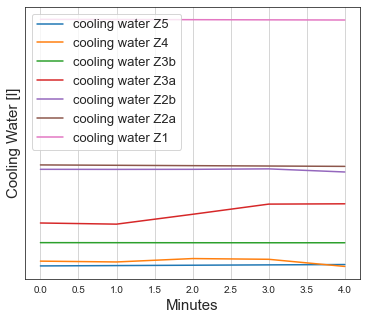

In [54]:
fig, (ax1) = plt.subplots(1,1, figsize=(6, 5))
sns.lineplot(data=test_change_unsc[test_change_unsc['seq_id']==seq_number][5:].reset_index(drop=True),
             y='WasserZ5LsInLproMin_integr',x=test_change_unsc[test_change_unsc['seq_id']==seq_number][5:].reset_index(drop=True).index,
             ax=ax1, label='cooling water Z5')
sns.lineplot(data=test_change_unsc[test_change_unsc['seq_id']==seq_number][5:].reset_index(drop=True),
             y='WasserZ4LsInLproMin_integr',x=test_change_unsc[test_change_unsc['seq_id']==seq_number][5:].reset_index(drop=True).index,
             ax=ax1, label='cooling water Z4')
sns.lineplot(data=test_change_unsc[test_change_unsc['seq_id']==seq_number][5:].reset_index(drop=True),
             y='WasserZ3bLsInLproMin_integr',x=test_change_unsc[test_change_unsc['seq_id']==seq_number][5:].reset_index(drop=True).index,
             ax=ax1, label='cooling water Z3b')
sns.lineplot(data=test_change_unsc[test_change_unsc['seq_id']==seq_number][5:].reset_index(drop=True),
             y='WasserZ3aLsInLproMin_integr',x=test_change_unsc[test_change_unsc['seq_id']==seq_number][5:].reset_index(drop=True).index,
             ax=ax1, label='cooling water Z3a')
sns.lineplot(data=test_change_unsc[test_change_unsc['seq_id']==seq_number][5:].reset_index(drop=True),
             y='WasserZ2bLsInLproMin_integr',x=test_change_unsc[test_change_unsc['seq_id']==seq_number][5:].reset_index(drop=True).index,
             ax=ax1, label='cooling water Z2b')
sns.lineplot(data=test_change_unsc[test_change_unsc['seq_id']==seq_number][5:].reset_index(drop=True),
             y='WasserZ2aLsInLproMin_integr',x=test_change_unsc[test_change_unsc['seq_id']==seq_number][5:].reset_index(drop=True).index,
             ax=ax1, label='cooling water Z2a')
sns.lineplot(data=test_change_unsc[test_change_unsc['seq_id']==seq_number][5:].reset_index(drop=True),
             y='WasserZ1LsInLproMin_integr',x=test_change_unsc[test_change_unsc['seq_id']==seq_number][5:].reset_index(drop=True).index,
             ax=ax1, label='cooling water Z1')
ax1.set_ylabel('Cooling Water [l]', fontsize=15)
ax1.xaxis.grid(True)
ax1.set(yticks=[]) 
ax1.set_xlabel('Minutes', fontsize=15)
ax1.legend(loc='upper left', prop={'size': 13})

Casting speed curve:

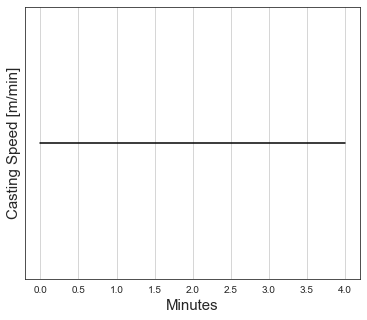

In [55]:
fig, (ax1) = plt.subplots(1, figsize=(6, 5))
sns.lineplot(data=test_change_unsc[test_change_unsc['seq_id']==seq_number][5:].reset_index(drop=True),
             y='GiessLaengeSequenzInM_delta',x=test_change_unsc[test_change_unsc['seq_id']==seq_number][5:].reset_index(drop=True).index,
             ax=ax1, color='black')
ax1.set_xlabel('Minutes', fontsize=15  )
ax1.set_ylabel('Casting Speed [m/min]', fontsize=15 )
ax1.set(yticks=[]) 
ax1.xaxis.grid(True)
ax1.yaxis.grid(True)


### Plot for all sequences in test set

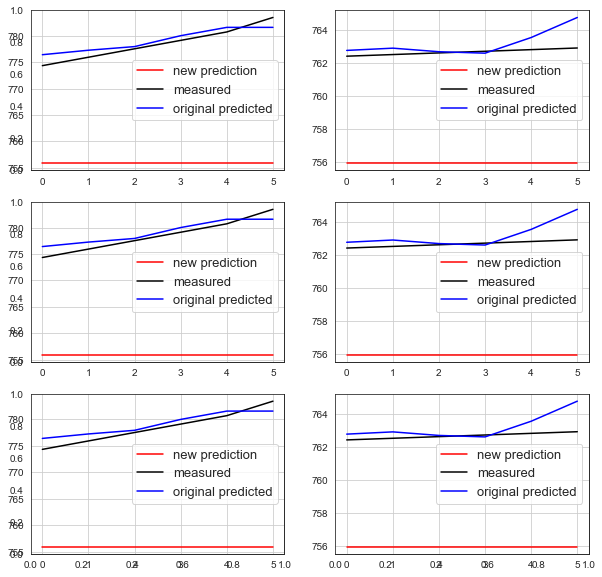

In [56]:
fig_test_data, axes = plt.subplots(3, 2, figsize=(10, 10),sharey=True, sharex=True)

ax = {}
i = 1
for seq in test_seq:
    ax[seq] = fig_test_data.add_subplot(3,2,i)
    ax[seq].plot(prediction_all_changed[seq][:,:1], color='red', label='new prediction')
    ax[seq].plot(real_values[seq][:,:1], color='black', label='measured')
    ax[seq].plot(prediction[seq][:,:1], color='blue', label='original predicted')
    ax[seq].grid()
    ax[seq].legend(loc='best', prop={'size': 13})
    i += 1

## Train Model without specific features

In [57]:
feature_keys

['TundishTemperaturInC',
 'WasserZ4FsInLproMin_integr',
 'WasserZ4LsInLproMin_integr',
 'WasserZ2bFsInLproMin_integr',
 'WasserZ2bLsInLproMin_integr',
 'WasserZ3bFsInLproMin_integr',
 'WasserZ1FsInLproMin_integr',
 'WasserZ3bLsInLproMin_integr',
 'WasserZ1LsInLproMin_integr',
 'WasserZ3aFsInLproMin_integr',
 'WasserZ3aLsInLproMin_integr',
 'WasserZ2aLsInLproMin_integr',
 'WasserZ2aFsInLproMin_integr',
 'WasserZ5LsInLproMin_integr',
 'WasserZ5FsInLproMin_integr',
 'GiessLaengeSchmelzeInM',
 'GiessLaengeSequenzInM',
 'AusfLaengeSchmelzeInM',
 'LiquidusTempInC',
 'SolidusTempInC',
 'UeberhitzungMittelInK',
 'ZielTempTreiberInC',
 'SollGiessGeschwInMproMin',
 'C-Aequiv01',
 'C-Aequiv02',
 'C-AequivP',
 'GiessLaengeSequenzInM_delta',
 'AusfLaengeSchmelzeInM_delta',
 'Format_2235']

In [58]:
not_used = ['ZielTempTreiberInC']  ## exclude feature
new_features = [e for e in feature_keys if e not in not_used]

Transform data in LSTM format:

In [59]:
def lstm_format_new_features(data):
    length_cc4 = 15.42
    seq_len = 5
    features = []
    labels = []
    data_set = {}

    for _, group in data.groupby('seq_id'):
        for i in range(len(group)-(seq_len-1)):
            features.append(group[new_features].iloc[i:i+seq_len].to_numpy())  
            labels.append(group[label_keys].iloc[i+(seq_len-1)].to_numpy())

    data_set['x'] = np.stack(features)
    data_set['y'] = np.stack(labels)
    return data_set

test_n = lstm_format_new_features(test_norm)
test_x_norm = test_n['x'].copy()
test_y_norm = test_n['y'].copy()

all_train_n = lstm_format_new_features(all_train_norm)
all_train_x_norm = all_train_n['x'].copy()
all_train_y_norm = all_train_n['y'].copy()

Train the best LSTM model with new features:

In [60]:
LSTMDropout_model = keras.models.Sequential([
    keras.layers.LSTM(16,
                      input_shape=(all_train_x_norm.shape[1],all_train_x_norm.shape[2]),
                      return_sequences=True,
                      dropout=0.3,
                      recurrent_dropout=0.3,
                      kernel_constraint=keras.constraints.max_norm(max_value=1),
                      recurrent_constraint=keras.constraints.max_norm(max_value=1),
                      ),
    
    keras.layers.LSTM(16,
                    return_sequences=True,
                    dropout=0.3,
                    recurrent_dropout=0.3,
                    kernel_constraint=keras.constraints.max_norm(max_value=1),
                    recurrent_constraint=keras.constraints.max_norm(max_value=1),
                     ),
    
    keras.layers.LSTM(16,
                    return_sequences=False,
                    dropout=0.3,
                    recurrent_dropout=0.3,
                    kernel_constraint=keras.constraints.max_norm(max_value=1),
                    recurrent_constraint=keras.constraints.max_norm(max_value=1),
                    ),
    
    keras.layers.Dense(2, kernel_initializer='he_normal')
])

LSTMDropout_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=1e-3))
LSTMDropout_model.summary()


LSTMDropout_history = LSTMDropout_model.fit(all_train_x_norm, all_train_y_norm,
                    epochs=99,
                    batch_size=128, 
                    verbose=2
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 16)             2880      
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 16)             2112      
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 7,138
Trainable params: 7,138
Non-trainable params: 0
_________________________________________________________________
Epoch 1/99
1/1 - 8s - loss: 0.5166
Epoch 2/99
1/1 - 0s - loss: 0.4987
Epoch 3/99
1/1 - 0s - loss: 0.4895
Epoch 4/99
1/1 - 0s - loss: 0.4756
Epoch 5/99
1/1 - 0s - loss: 0.4617
Epoch 6/99
1/1 - 0s - loss: 0.4476
Epoch 7/99
1/1 - 0s - loss: 0.4328
Epoch

### RMSE of new Model:

In [61]:
y_pred_test= LSTMDropout_model.predict(test_x_norm)
y_test_unsc = scaler_y.inverse_transform(test_y_norm)
y_pred_test_unsc = scaler_y.inverse_transform(y_pred_test)
print('RMSE of new model:')
np.sqrt(mean_squared_error(y_pred_test_unsc, y_test_unsc))  

RMSE of new model:


3.367518606343815

### Effect to prediction of a single sequence

Bring data in the LSTM format:

In [62]:
def lstm_format(data):
    length_cc4 = 15.42
    seq_len = 5
    features = []
    labels = []
    data_set = {}

    for _, group in data.groupby('seq_id'):
        for i in range(len(group)-(seq_len-1)):
            features.append(group[new_features].iloc[i:i+seq_len].to_numpy())   ##Achtung keys wieder ändern!
            labels.append(group[label_keys].iloc[i+(seq_len-1)].to_numpy())

    data_set['x'] = np.stack(features)
    data_set['y'] = np.stack(labels)
    return data_set

test_seq = test_norm['seq_id'].drop_duplicates()

x = {}
y = {}
for seq in test_seq:
    df = lstm_format(test_norm[test_norm['seq_id']==seq])
    x[seq]= df['x'].copy()
    y[seq] = df['y'].copy()

prediction = {}
real_values = {}
rmse = {}
for seq in test_seq:
    prediction[seq] = scaler_y.inverse_transform(LSTMDropout_model.predict(x[seq]))
    real_values[seq] = scaler_y.inverse_transform(y[seq])
    rmse[seq] = np.sqrt(mean_squared_error( prediction[seq],  real_values[seq]))  

error = []
for seq in test_seq:
    error.append((rmse[seq], seq))

In [63]:
sorted(error)

[(1.974470723152505, '471719_str_2'),
 (1.974470723152505, '471724_str_2'),
 (1.974470723152505, '471728_str_2'),
 (4.333800698181356, '471719_str_1'),
 (4.333800698181356, '471724_str_1'),
 (4.333800698181356, '471728_str_1')]

Look at new prediction:

RMSE: 1.974470723152505


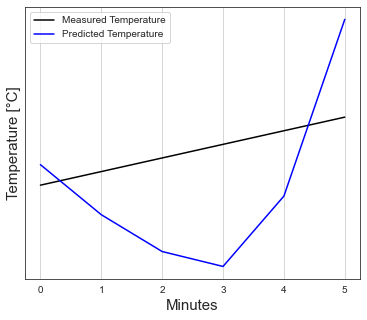

In [64]:
sequences_name = '471719_str_2'

fig, (ax1) = plt.subplots(1, figsize=(6, 5),  sharex=True, sharey=True)
ax1.plot(real_values[sequences_name][:,:1], color='black', label='Measured Temperature')
ax1.plot(prediction[sequences_name][:,:1], color='blue', label='Predicted Temperature')
ax1.legend(loc='best')
#ax1.set_title('Comparison Between Measured and Predicted Temperatures for Sequence '+str(sequences_name))
ax1.set_ylabel('Temperature')
ax1.tick_params(axis='both', which='both', labelbottom=True)
ax1.grid()
ax1.set_xlabel('Minutes', fontsize=15)
ax1.set_ylabel('Temperature [°C]',fontsize=15)
ax1.set(yticks=[]) 

print('RMSE:', rmse[sequences_name] )